# Samsara TSP Data Quality Assessment (SS, Oct 2021)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import getpass
import psycopg2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import gzip
import json
# from tqdm import tqdm
import seaborn as sns

# 1. Samsara

In [2]:
# Get safety events
safety_events_data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events'
safety_events_data_files = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(safety_events_data_path) for filename in filenames if 'DS_Store' not in filename]
safety_events_data_df = pd.concat([pd.read_json(file, compression='gzip', lines=True) for file in safety_events_data_files[0]], ignore_index = True)
safety_events_data_df

IsADirectoryError: [Errno 21] Is a directory: '/'

In [ ]:
# pd.read_json(safety_events_data_files[0], compression='gzip', lines=True)
with gzip.open(safety_events_data_files[0], 'r') as fin:
    data = fin.read().decode('utf-8')

In [ ]:
data

In [ ]:
data_list =[]
for line in data:
    print(line)
    # data_list.append(json.loads(line))

In [ ]:
data

In [296]:
json.loads(data)

JSONDecodeError: Extra data: line 1 column 603 (char 602)

In [289]:
tweets = []


for line in open(safety_events_data_files[0], 'r'):
    data = json.loads(fin.read().decode('utf-8'))   
    tweets.append(json.loads(line.decode('utf-8')))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte

In [273]:
safety_events_data_files[0]

'/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/03/200f639c-5293-4ba0-9e7a-335fc2169317'

In [281]:
# Get vehicle stats
vehicle_stats_data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats'
vehicle_stats_data_files = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(vehicle_stats_data_path) for filename in filenames if 'DS_Store' not in filename]
vehicle_stats_data_df = pd.concat([pd.read_json(file, compression='gzip', lines=True) for file in vehicle_stats_data_files], ignore_index = True)
vehicle_stats_data_df

ValueError: Unexpected character found when decoding array value (2)

In [248]:
for e in os.walk(safety_events_data_path):
    print(e)

In [234]:
# Pull the data
trakm8_data_df = pd.concat([pd.read_excel(file) for file in trakm8_data_files], ignore_index = True)
trakm8_data_df

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN
0,Heartbeat,357788108263491,18/07/2021 00:57:42 (BST),50.858787,-1.269916,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX
1,Heartbeat,357788108263491,18/07/2021 06:57:43 (BST),50.858808,-1.269878,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX
2,Heartbeat,357788108263491,18/07/2021 12:57:44 (BST),50.858766,-1.269970,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX
3,Heartbeat,357788108263491,18/07/2021 19:02:25 (BST),50.858787,-1.269916,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX
4,Heartbeat,357788108263491,19/07/2021 01:04:54 (BST),50.858787,-1.269916,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX
...,...,...,...,...,...,...,...,...,...
38396,GPS Periodic,357788108159467,07/08/2021 16:58:18 (BST),50.851978,-1.287429,0.0,NaN,NaN,SALFA2AB0AH18XXXX
38397,Ignition Off,357788108159467,07/08/2021 16:58:30 (BST),50.851978,-1.287426,0.0,NaN,NaN,SALFA2AB0AH18XXXX
38398,Journey End,357788108159467,07/08/2021 16:58:31 (BST),50.851978,-1.287426,0.0,NaN,NaN,SALFA2AB0AH18XXXX
38399,Heartbeat,357788108159467,07/08/2021 17:29:19 (BST),50.851980,-1.287420,0.0,NaN,NaN,SALFA2AB0AH18XXXX


In [113]:
# Adjust the timestamps
trakm8_data_df['Time_adjusted'] = pd.to_datetime(trakm8_data_df['Time'], format="%d/%m/%Y %H:%M:%S (BST)", utc=True, errors='coerce')
trakm8_data_df['Time_adjusted'] = np.where(
    trakm8_data_df['Time_adjusted'].isna(),
    pd.to_datetime(trakm8_data_df['Time'], format="%d/%m/%Y %H:%M:%S (WET+1)", utc=True, errors='coerce'),
    trakm8_data_df['Time_adjusted']
)
trakm8_data_df.loc[13822, 'Time_adjusted'] =  pd.to_datetime(trakm8_data_df[trakm8_data_df['Time_adjusted'].isna()]['Time'],
                                                                                         format="%d/%m/%Y %H:%M:%S", utc=True).values
trakm8_data_df['Time_adjusted'] = pd.to_datetime(trakm8_data_df['Time_adjusted'], utc=True).dt.tz_localize(None)

In [130]:
# Sample size
pd.to_datetime(trakm8_data_df['Time_adjusted'])

0       2021-07-18 00:57:42
1       2021-07-18 06:57:43
2       2021-07-18 12:57:44
3       2021-07-18 19:02:25
4       2021-07-19 01:04:54
                ...        
38396   2021-08-07 16:58:18
38397   2021-08-07 16:58:30
38398   2021-08-07 16:58:31
38399   2021-08-07 17:29:19
38400   2021-08-07 23:29:20
Name: Time_adjusted, Length: 38401, dtype: datetime64[ns]

In [131]:
# Daterange
print(f'Min date {trakm8_data_df.Time_adjusted.min()}, \
      \nMax date {trakm8_data_df.Time_adjusted.max()}, \
      \nDate range {trakm8_data_df.Time_adjusted.max() - trakm8_data_df.Time_adjusted.min()}')

Min date 2021-07-04 10:15:14,       
Max date 2021-08-07 23:29:20,       
Date range 34 days 13:14:06


In [134]:
# Vehicles
trakm8_data_df['IMEI'].value_counts()

352255060717406    9928
352255062655430    7157
357788100159887    4960
358636084204790    4659
358636084505667    3560
357788108159467    2626
866758047635814    2360
353386065894764    1639
357788108263491    1512
Name: IMEI, dtype: int64

In [136]:
# VINs
trakm8_data_df['VIN'].value_counts()

WF0FXXWPCFJP2XXXX    9928
YV1XZ14V1K2XXXXXX    4659
WAUZZZ8V9KA10XXXX    3560
SALFA2AB0AH18XXXX    2626
WF0EXXWPCEKXXXXXX    2360
WVWZZZAUZJWXXXXXX    1639
WAUZZZ8P0BA14XXXX    1512
Name: VIN, dtype: int64

In [143]:
# Events
trakm8_data_df['Message'].value_counts()

GPS Periodic             32890
Ignition On                932
Ignition Off               931
Speeding Ended             896
Heartbeat                  766
Journey Start              732
Journey End                731
Harsh Braking              185
Harsh Acceleration         149
Harsh Right Cornering       77
Idle Ongoing                27
Harsh Left Cornering        23
Idle End                    12
Idle Start                  12
RPM Over Threshold          10
Excessive Idle               7
Power Restored               5
VIN                          4
Device Removed               3
Power Lost                   3
Device Inserted              3
DFB Calibration Event        2
Vehicle Changed              1
Name: Message, dtype: int64

Text(0.5, 0, 'Time Interval (Minutes)')

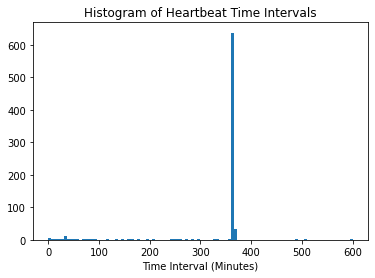

In [168]:
#  Histogram of heartbeat frequencies
plt.hist(
    trakm8_data_df[trakm8_data_df['Message'] == 'Heartbeat'].Time_adjusted.diff() / np.timedelta64(1, 'm'),
    range=[0, 600], 
    bins=100
)
plt.title('Histogram of Heartbeat Time Intervals')
plt.xlabel('Time Interval (Minutes)')

Text(0.5, 0, 'Time Interval (Seconds)')

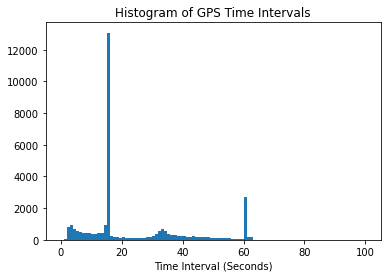

In [179]:
#  Histogram of GPS location frequencies
plt.hist(
    trakm8_data_df[trakm8_data_df['Message'] == 'GPS Periodic'].Time_adjusted.diff() / np.timedelta64(1, 's'),
    range=[0, 100], 
    bins=100
)
plt.title('Histogram of GPS Time Intervals')
plt.xlabel('Time Interval (Seconds)')

In [191]:
# Speeding
trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
403,Speeding Ended,357788108263491,21/07/2021 16:00:31 (BST),50.959874,-1.425760,80.0,80.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:00:31
405,Speeding Ended,357788108263491,21/07/2021 16:01:14 (BST),50.957739,-1.447338,91.0,91.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:01:14
411,Speeding Ended,357788108263491,21/07/2021 16:03:10 (BST),50.940173,-1.473303,74.0,74.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:03:10
412,Speeding Ended,357788108263491,21/07/2021 16:03:25 (BST),50.935858,-1.473254,72.0,72.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:03:25
468,Speeding Ended,357788108263491,21/07/2021 19:43:43 (BST),50.943521,-1.474988,89.0,89.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 19:43:43
...,...,...,...,...,...,...,...,...,...,...
37300,Speeding Ended,357788108159467,28/07/2021 18:02:44 (BST),50.920215,-1.590156,71.0,71.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:02:44
37307,Speeding Ended,357788108159467,28/07/2021 18:05:59 (BST),50.946375,-1.514161,81.0,81.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:05:59
37313,Speeding Ended,357788108159467,28/07/2021 18:08:16 (BST),50.955848,-1.454610,78.0,78.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:08:16
37560,Speeding Ended,357788108159467,30/07/2021 10:33:12 (BST),50.855904,-1.130621,72.0,72.0,70.0,SALFA2AB0AH18XXXX,2021-07-30 10:33:12


In [214]:
trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']['Threshold'].value_counts()

70.0    896
Name: Threshold, dtype: int64

Text(0.5, 0, 'Speed (MPH)')

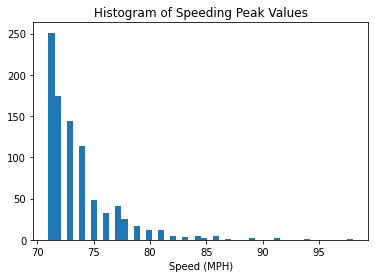

In [201]:
#  Histogram of Overspeedings
plt.hist(
    trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']['Peak Value'],
    # range=[0, 100], 
    bins=50
)
plt.title('Histogram of Speeding Peak Values')
plt.xlabel('Speed (MPH)')

In [204]:
# Idling
trakm8_data_df[trakm8_data_df['Message'].str.contains("Idle")]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
75,Idle Start,357788108263491,19/07/2021 14:27:59 (BST),50.917810,-1.315235,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:27:59
77,Excessive Idle,357788108263491,19/07/2021 14:28:59 (BST),50.917839,-1.315081,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:28:59
78,Idle Ongoing,357788108263491,19/07/2021 14:28:59 (BST),50.917839,-1.315081,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:28:59
80,Idle Ongoing,357788108263491,19/07/2021 14:29:59 (BST),50.917842,-1.314984,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:29:59
82,Idle Ongoing,357788108263491,19/07/2021 14:30:59 (BST),50.917788,-1.314922,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:30:59
84,Idle Ongoing,357788108263491,19/07/2021 14:31:59 (BST),50.917732,-1.314935,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:31:59
85,Idle End,357788108263491,19/07/2021 14:32:04 (BST),50.917745,-1.314922,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:32:04
646,Idle Start,357788108263491,22/07/2021 16:00:27 (BST),50.868697,-1.281009,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:00:27
648,Excessive Idle,357788108263491,22/07/2021 16:01:27 (BST),50.868691,-1.281003,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:01:27
649,Idle Ongoing,357788108263491,22/07/2021 16:01:27 (BST),50.868691,-1.281003,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:01:27


In [213]:
# Device status
trakm8_data_df[trakm8_data_df['Message'].isin(trakm8_data_df['Message'].value_counts()[-7:].index)]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
13822,Power Restored,358636084505667,20/07/2021 09:23:49,0.000000,0.000000,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 09:23:49
13824,Device Removed,358636084505667,20/07/2021 10:25:21 (BST),53.773666,-1.529307,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:21
13827,Power Lost,358636084505667,20/07/2021 10:25:25 (BST),53.773657,-1.529305,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:25
13830,Power Restored,358636084505667,20/07/2021 10:25:55 (BST),53.773650,-1.529307,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:55
13831,Device Inserted,358636084505667,20/07/2021 10:25:55 (BST),53.773650,-1.529307,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:55
13833,Device Removed,358636084505667,20/07/2021 10:27:12 (BST),53.773638,-1.529280,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:12
13834,Power Lost,358636084505667,20/07/2021 10:27:17 (BST),53.773623,-1.529277,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:17
13836,Power Restored,358636084505667,20/07/2021 10:27:37 (BST),53.773621,-1.529248,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:37
13837,Device Inserted,358636084505667,20/07/2021 10:27:37 (BST),53.773621,-1.529248,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:37
13844,VIN,358636084505667,20/07/2021 16:33:50 (BST),53.773287,-1.529247,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 16:33:50


In [224]:
# Harsh events
trakm8_data_df[trakm8_data_df['Message'].isin(['Harsh Braking', 'Harsh Acceleration', 'Harsh Right Cornering', 'Harsh Left Cornering'])]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
136,Harsh Left Cornering,357788108263491,19/07/2021 16:00:37 (BST),50.869705,-1.254843,34.0,46.0,45.0,WAUZZZ8P0BA14XXXX,2021-07-19 16:00:37
183,Harsh Acceleration,357788108263491,19/07/2021 20:07:36 (BST),50.955491,-1.371604,19.0,28.2,25.0,WAUZZZ8P0BA14XXXX,2021-07-19 20:07:36
239,Harsh Acceleration,357788108263491,20/07/2021 16:50:32 (BST),50.862501,-1.254019,21.0,40.6,25.0,WAUZZZ8P0BA14XXXX,2021-07-20 16:50:32
338,Harsh Acceleration,357788108263491,20/07/2021 20:57:33 (BST),50.915378,-1.357788,36.0,27.6,25.0,WAUZZZ8P0BA14XXXX,2021-07-20 20:57:33
378,Harsh Acceleration,357788108263491,21/07/2021 15:46:38 (BST),50.862648,-1.254062,19.0,40.8,25.0,WAUZZZ8P0BA14XXXX,2021-07-21 15:46:38
...,...,...,...,...,...,...,...,...,...,...
35589,Harsh Braking,352255060717406,06/08/2021 18:51:43 (BST),51.788044,-0.622476,34.0,32.6,30.0,WF0FXXWPCFJP2XXXX,2021-08-06 18:51:43
35598,Harsh Braking,352255060717406,06/08/2021 18:53:54 (BST),51.797178,-0.605062,26.0,46.8,30.0,WF0FXXWPCFJP2XXXX,2021-08-06 18:53:54
36787,Harsh Braking,357788108159467,26/07/2021 16:31:11 (BST),50.872260,-1.271881,21.0,37.6,30.0,SALFA2AB0AH18XXXX,2021-07-26 16:31:11
36810,Harsh Braking,357788108159467,26/07/2021 16:44:55 (BST),50.948425,-1.368830,21.0,33.1,30.0,SALFA2AB0AH18XXXX,2021-07-26 16:44:55


In [225]:
trakm8_data_df[trakm8_data_df['Message'].isin(['Harsh Braking', 'Harsh Acceleration', 'Harsh Right Cornering', 'Harsh Left Cornering'])]['Threshold'].value_counts()

30.0    185
25.0    149
45.0    100
Name: Threshold, dtype: int64

In [229]:
# RPM
trakm8_data_df[trakm8_data_df['Message'].isin(['RPM Over Threshold'])]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
15397,RPM Over Threshold,358636084505667,07/08/2021 15:49:42 (BST),53.776032,-1.581325,40.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-08-07 15:49:42
15409,RPM Over Threshold,358636084505667,07/08/2021 15:54:29 (BST),53.798130,-1.561857,36.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-08-07 15:54:29
16064,RPM Over Threshold,358636084505667,27/07/2021 09:52:03 (BST),52.622376,-1.800500,33.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 09:52:03
16065,RPM Over Threshold,358636084505667,27/07/2021 09:52:09 (BST),52.621346,-1.800418,53.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 09:52:09
16095,RPM Over Threshold,358636084505667,27/07/2021 10:00:16 (BST),52.528534,-1.722835,49.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 10:00:16
16104,RPM Over Threshold,358636084505667,27/07/2021 10:03:40 (BST),52.511397,-1.709670,14.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 10:03:40
16168,RPM Over Threshold,358636084505667,27/07/2021 16:58:15 (BST),52.539851,-1.729934,55.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 16:58:15
16170,RPM Over Threshold,358636084505667,27/07/2021 16:58:28 (BST),52.543544,-1.729719,71.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 16:58:28
16202,RPM Over Threshold,358636084505667,27/07/2021 17:14:54 (BST),52.668104,-2.001177,38.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 17:14:54
16203,RPM Over Threshold,358636084505667,27/07/2021 17:14:59 (BST),52.668692,-2.002553,57.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 17:14:59


In [230]:
# Uniform sampling per vehicle/device